# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 7: Artificial Neural Networks, Model Interpretation, and Regularization


**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf

%matplotlib inline

<hr style="height:2pt">

### INSTRUCTIONS

- **THIS IS AN INDIVIDUAL ASSIGNMENT.**

- **DO NOT PROCRASTINATE! Expect your completed code in this notebook to take 20-60 minutes to run depending on your computer hardware.**

- To submit your assignment follow the instructions given in Canvas.

- This assignment **must be done individually.**

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. Exceptions should be made for code with an extremely long execution time, of course.
- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.
- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 
- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example:
```python
print(f'The R^2 is {R:.4f}')
```
- Your plots should be clearly labeled, including clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95% confidence interval of coefficients of polynomial degree 5" is).

<hr style="height:2pt">

<a id="contents"></a>

# Notebook Contents

- [**PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**PART 2 [35 pts]: Kannada MNIST Kaggle competition**](#part2)
  - [Problem Statement](#part2intro)
  - [The Kannada MNIST Dataset](#part2about)
  - [Downloading the Data Files](#part2data)
  - [CS109A Kaggle Competition](#part2kaggle)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description

[Return to contents](#contents)

In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival. The model will be based on features that can be measured as the flight takes off.

We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.

The included variables are:

    
**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).

**DISTANCE**: the distance between arrival and departure airports, in miles.

**SCHEDULED_TIME**: the flight's scheduled travel time.

**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.

**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).

**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).

**FLIGHT_COUNT**: the number of flights flying out of the origin airport before noon on a typical day.

**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.

**ORIGIN_AIRPORT**: the airport the flight took off from.

**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.

For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.

**NOTE:** the observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

<!-- </div> -->

<a id="part1questions"></a>

## <div class='exercise'>PART 1: Questions</div> 

[Return to contents](#contents)

<a id="q11"></a>

**[1.1:](#s11) Preprocess the data**

Our first step will be to read in our dataset and preprocess our data.

- **[1.1.1:](#s11)**  Read in the dataset `flights.csv`. Create a variable `DELAY_OR_NOT` that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed only if it arrives 15 minutes late or more). This is going to be the response variable for the rest of this question. 


- **[1.1.2:](#s112)** Preprocess the data: deal with missing values if there are any, one-hot-encode the non-numeric categorical variables, and split and scale the data (use an 80/20 train-test split with `random_state=111`). Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets. **NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.

<a id="q12"></a>

**[1.2:](#s12) Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation function for the hidden layers, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for a reasonable number of epochs (you can base this number on the results of your training and validation accuracy plot), and feel free to use tensorflow's default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model` training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.

<a id="q13"></a>

**[1.3:](#s13) Fit and examine a "proxy" model**

To begin our interpretation of the resulting `NN_model`, we will first use a "proxy model" that we know how to interpret and train it on our `NN_model` class predictions rather than the true $y$ training values.


- **[1.3.1:](#s13)** First, generate a set of `NN_model` class predictions for the training set. These $\hat{y}$ training predictions will be used instead of the true $y$ training values when we fit our proxy model in 1.3.2. The $X$ values used in our 1.3.2 proxy model should be the same ones used for `NN_model`.


- **[1.3.2:](#s132)** Next, fit a logistic regression model using your $\hat{y}$ values from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Print the `logreg` test accuracy to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.


- **[1.3.3:](#s133)** Now use sklearn's `permutation_importance` function (already included in this notebook's imports) to compute the feature importance using the `logreg` model. Plot the **relative** feature importance for the top-10 most important predictors identified by the `permutation_importance` function.

  - Please refer to sklearn's official documentation to learn how this function works.
  
  - When running `permutation_importance` for this problem, you can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.

<a id="q14"></a>

**[1.4:](#s14) Visualize important features**

Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. **For all 1.4 plots below**, for ease of interpretation, **please be certain to** display all predictors on their original scales. **NOTE:** The predictors you are required to use in 1.4 may differ from some of the top-10 predictors you identified in 1.3 as a result of random variability in our algorithms.


   - **[1.4.1:](#s14)** Set all predictors to their means/modes except for `SCHED_DEP_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences.

 
   - **[1.4.2:](#s142)** Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `FLIGHT_COUNT` from the training set (see the question 1.4 "HINT" below).


   - **[1.4.3:](#s143)** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` from the training set.


   - **[1.4.4:](#s144)** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `DISTANCE` from the training set. 


  - **[1.4.5:](#s145)** In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.

**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your data points based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. Please refer to the matplotlib documentation for examples.

<a id="q15"></a>

**[1.5:](#s15) Bootstrap prediction intervals**

In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (a minimum $n$ of at least 50 bootstraps should be used). Predict the output on the test data for each model. Randomly select 8 test observations and on 8 subplots, plot the distribution of predicted probabilities (i.e. $n$ bootstrapped probabilites) with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

<a id="q16"></a>

**[1.6:](#s16) Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how "significant" our bagged (i.e. bootstrap-aggregated) prediction will be for each test observation.

To accomplish this, you will first calculate the ratio of bootstrapped probabilities that cross the threshold value of $\hat{p}=0.5$. Let's call this ratio the **Posterior Prediction Ratio (PPR)**. When a bagged prediction's $PPR=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPR=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPR$ values for all test observations, you should have $n=2000$ $PPR$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for significance (i.e. maximum $PPR$ value) is not met. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPR$ threshold). You can make your abstain model *stricter* by using smaller $PPR$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPR$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPR$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPR$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model predicts confidently. 


<a id="part1solutions"></a>

## PART 1: Solutions

[Return to contents](#contents)


<a id="s11"></a>
<div class='exercise-r'>  

**[1.1:](#q11) Preprocess the data**

Our first step will be to read in our dataset and preprocess our data.

**[1.1.1:](#q11)** Read in the dataset `flights.csv`. Create a variable `DELAY_OR_NOT` that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed only if it arrives 15 minutes late or more). This is going to be the response variable for the rest of this question. 

</div>

In [3]:
# your code here 
flights = pd.read_csv('data/flights.csv')
flights['DELAY_OR_NOT'] = 1*(flights['ARRIVAL_DELAY'] > 15)
flights.drop('ARRIVAL_DELAY', axis=1, inplace=True)
flights.head(5)

,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
0,2586.0,342.0,9,7,15,240.0,3,SFO,JFK,1
1,1235.0,185.0,5,6,11,366.0,4,LAX,DFW,0
2,184.0,76.0,4,17,18,172.0,7,BOS,LGA,0
3,862.0,148.0,7,19,21,260.0,7,IAH,DEN,1
4,236.0,71.0,3,20,21,266.0,2,LAS,LAX,1


<a id="s112"></a>
<div class='exercise-r'>  

**[1.1.2:](#q11)** Preprocess the data: deal with missing values if there are any, one-hot-encode the non-numeric categorical variables, and split and scale the data (use an 80/20 train-test split with `random_state=111`). Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets. **NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.
    
</div>

In [4]:
# your code here
print('The number of missing values is ', flights.isna().sum().sum())

The number of missing values is  11


We are going to proceed with data imputation. The two methods we will leverage are:
- kNN imputation, which allows to deal with missing values
- Missing Indicator: a binary variable that indicates whether or not a value was missing in an observation. 

I would do that if I needed those missing values. In that case, since we have 10000 observations, I won't lose that much time with 0.1% of the data.

In [5]:
flights.dropna(inplace=True)

In [6]:
categorical_columns = ['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
for column_category in categorical_columns:
    dummies = pd.get_dummies(flights[column_category], drop_first=True)
    dummies.columns = [column + column_category.split('_')[0] for column in dummies.columns]
    flights = flights.join(dummies)

In [7]:
flights.drop(categorical_columns, axis=1, inplace=True)
X, y = flights.drop(['DELAY_OR_NOT'], axis=1), (flights['DELAY_OR_NOT'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7996, 808) (1999, 808) (7996,) (1999,)


In [8]:
Scaler = StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

<a id="s12"></a>
<div class='exercise-r'>  
    
**[1.2:](#q12) Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation function for the hidden layers, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for a reasonable number of epochs (you can base this number on the results of your training and validation accuracy plot), and feel free to use tensorflow's default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model` training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.
    
</div>

In [9]:
# build your NN 
# your code here
dim_input = X.shape[1]
dim_output = 1 # binary classification
NN_model = tf.keras.models.Sequential(name='NN_model')
hidden_layers = 2  # depth
width_hidden_layers = 15 
NN_model.add((tf.keras.layers.Dense(width_hidden_layers,input_dim=dim_input, activation = 'relu',name='hidden1')))
NN_model.add((tf.keras.layers.Dense(width_hidden_layers, activation = 'relu',name='hidden2')))
NN_model.add(tf.keras.layers.Dense(dim_output, activation = 'sigmoid',name='output'))
NN_model.summary()

Model: "NN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 15)                12135     
_________________________________________________________________
hidden2 (Dense)              (None, 15)                240       
_________________________________________________________________
output (Dense)               (None, 1)                 16        
Total params: 12,391
Trainable params: 12,391
Non-trainable params: 0
_________________________________________________________________


In [10]:
# compile it and run it
# your code here 
NN_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
history = NN_model.fit(X_train_scaled, y_train, epochs=40, batch_size=64, verbose=1, validation_split=0.2)

Epoch 1/40
100/100 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5624 - val_loss: 0.6649 - val_accuracy: 0.6044
Epoch 2/40
100/100 [==============================] - 0s 2ms/step - loss: 0.5993 - accuracy: 0.6881 - val_loss: 0.6261 - val_accuracy: 0.6644
Epoch 3/40
100/100 [==============================] - 0s 2ms/step - loss: 0.5328 - accuracy: 0.7409 - val_loss: 0.6119 - val_accuracy: 0.6831
Epoch 4/40
100/100 [==============================] - 0s 3ms/step - loss: 0.4957 - accuracy: 0.7655 - val_loss: 0.6166 - val_accuracy: 0.6869
Epoch 5/40
100/100 [==============================] - 0s 3ms/step - loss: 0.4739 - accuracy: 0.7788 - val_loss: 0.6233 - val_accuracy: 0.6944
Epoch 6/40
100/100 [==============================] - 0s 2ms/step - loss: 0.4569 - accuracy: 0.7889 - val_loss: 0.6342 - val_accuracy: 0.6963
Epoch 7/40
100/100 [==============================] - 0s 2ms/step - loss: 0.4448 - accuracy: 0.7985 - val_loss: 0.6424 - val_accuracy: 0.7006
Epoch 

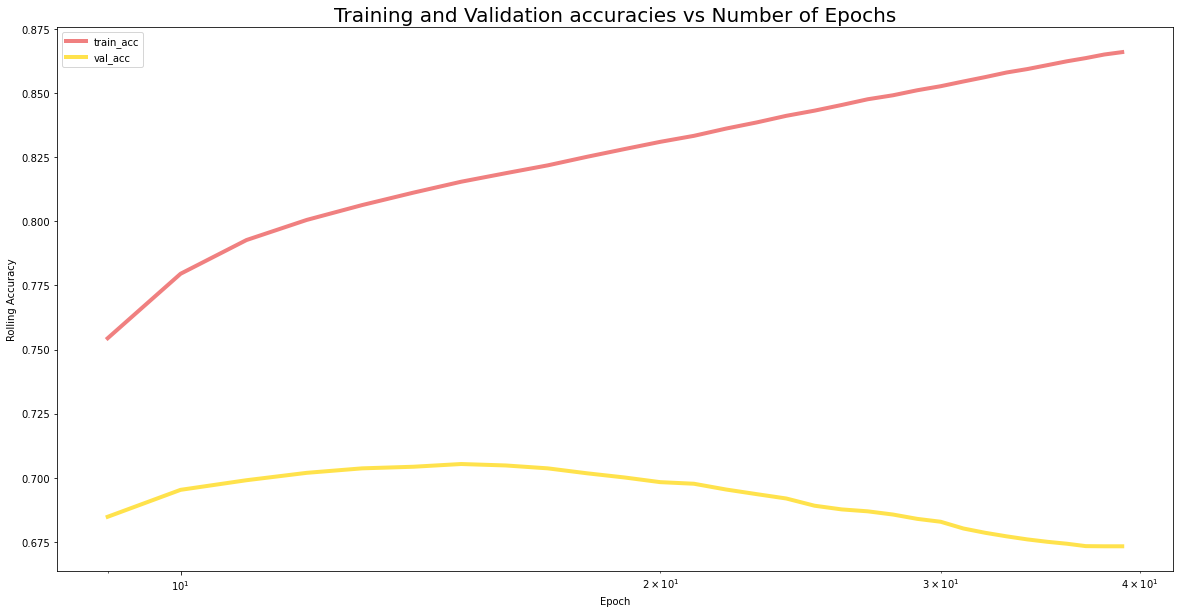

In [11]:
# plot train and val acc as a function of epochs
# your code here
def get_rolling_avg(arr, rolling = 10):
    return pd.Series(arr).rolling(rolling).mean()

rollNum = 10
fig, ax = plt.subplots(1, figsize= (20, 10))
ax.semilogx(get_rolling_avg(history.history['accuracy'],rollNum), label = 'train_acc', linewidth=4, color='lightcoral')
ax.semilogx(get_rolling_avg(history.history['val_accuracy'],rollNum), label = 'val_acc', linewidth=4, alpha=.7, color='gold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Rolling Accuracy')
ax.legend()
ax.set_title('Training and Validation accuracies vs Number of Epochs', size =20)
plt.show(fig)

In [12]:
# evaluate on train and test and print accuracy results
# your code here 
train_accuracy = NN_model.evaluate(X_train_scaled,y_train)[1]
test_accuracy = NN_model.evaluate(X_test_scaled, y_test)[1]
print(f'The training set accuracy for the model is {train_accuracy}\
    \n The test set accuracy for the model is {test_accuracy}')

63/63 [==============================] - 0s 2ms/step - loss: 1.1069 - accuracy: 0.6693
The training set accuracy for the model is 0.8437969088554382    
 The test set accuracy for the model is 0.6693346500396729


This model highly overfits our training data. 

<a id="s13"></a>
<div class='exercise-r'>

**[1.3:](#q13) Fit and examine a "proxy" model**

To begin our interpretation of the resulting `NN_model`, we will first use a "proxy model" that we know how to interpret and train it on our `NN_model` class predictions rather than the true $y$ training values.
    
**[1.3.1:](#q13)** First, generate a set of `NN_model` class predictions for the training set. These $\hat{y}$ training predictions will be used instead of the true $y$ training values when we fit our proxy model in 1.3.2. The $X$ values used in our 1.3.2 proxy model should be the same ones used for `NN_model`.

</div>

In [13]:
# your code here
predictions_train = NN_model.predict_classes(X_train_scaled).flatten()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<a id="s132"></a>
<div class='exercise-r'>
    
**[1.3.2:](#q13)** Next, fit a logistic regression model using your $\hat{y}$ values from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Print the `logreg` test accuracy to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.

</div>

In [14]:
# your code here
from sklearn.linear_model import LogisticRegressionCV
import warnings

warnings.filterwarnings('ignore')
Cs = np.logspace(-6, 2, 9)
logreg = LogisticRegressionCV(penalty='l2', solver='lbfgs', Cs=Cs[6:8], scoring='accuracy', max_iter=2000, n_jobs=-1)
logreg.fit(X_train_scaled, predictions_train)
test_logreg = logreg.score(X_test_scaled, y_test)
print('The test accuracy of our logistic regression trained on the predictions of the Neural Network are ', test_logreg)

The test accuracy of our logistic regression trained on the predictions of the Neural Network are  0.7028514257128564


The test accuracy for our logreg model is similar to the one we have seen with the NN_model.

<a id="s133"></a>
<div class='exercise-r'>

**[1.3.3:](#q13)** Now use sklearn's `permutation_importance` function (already included in this notebook's imports) to compute the feature importance using the `logreg` model. Plot the **relative** feature importance for the top-10 most important predictors identified by the `permutation_importance` function.

  - Please refer to sklearn's official documentation to learn how this function works.
  
  - When running `permutation_importance` for this problem, you can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.

</div>

In [15]:
# your code here
r = permutation_importance(logreg, X_test_scaled, y_test, n_jobs=-1, random_state=0)

In [16]:
feature_importance = {}
for i in r.importances_mean.argsort()[::-1]:
    feature_importance[list(flights.columns)[i]] = [r['importances_mean'][i], r['importances_std'][i]]

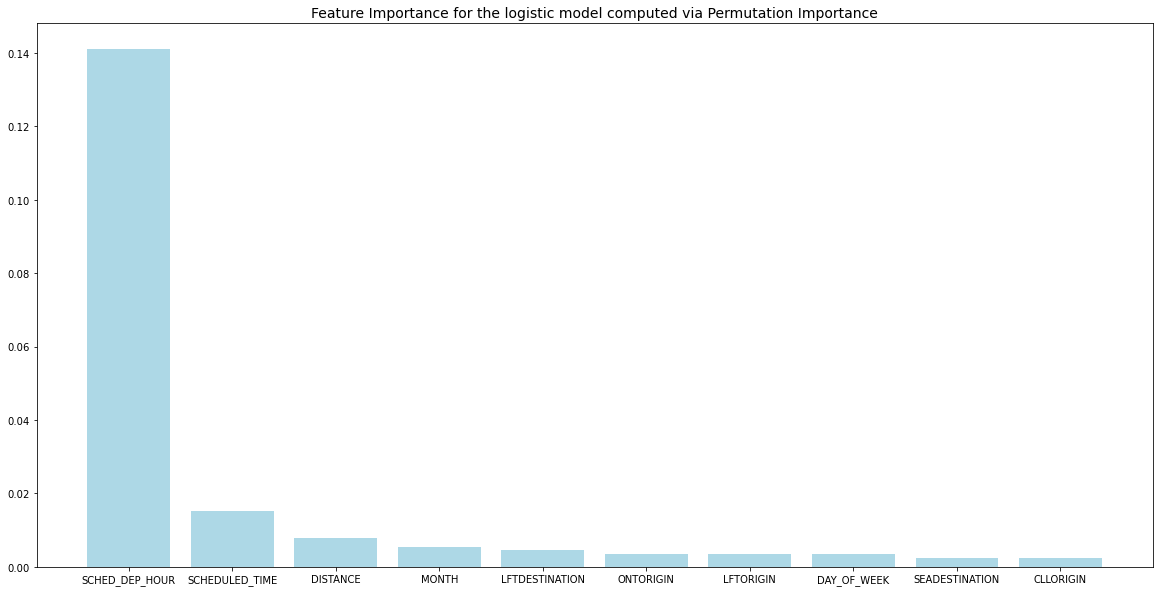

In [17]:
fig, ax = plt.subplots(1, figsize = (20, 10))
ax.bar(x = list(feature_importance.keys())[:10], height = np.asarray(list(feature_importance.values()))[:10, 0], color='lightblue')
ax.set_title('Feature Importance for the logistic model computed via Permutation Importance', size=14)
plt.show(fig)

<a id="s14"></a>
<div class='exercise-r'>

**[1.4:](#q14) Visualize important features**

Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. **For all 1.4 plots below**, for ease of interpretation, **please be certain to** display all predictors on their original scales. **NOTE:** The predictors you are required to use in 1.4 may differ from some of the top-10 predictors you identified in 1.3 as a result of random variability in our algorithms.

**[1.4.1:](#q14)** Set all predictors to their means/modes except for `SCHED_DEP_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences. 

</div>

In [18]:
# your code here
constant_1 = pd.DataFrame()
for i, column in enumerate(X_train.columns):
    if column != 'SCHED_DEP_HOUR':
        if i < 7:
            constant_1[column] = X_train[column].mean()*np.ones(len(X_train[column]))
            
        else:
            constant_1[column] = 0*np.ones(len(X_train[column]))
    else:
        array = X_train[column].copy()
        constant_1[column]= X_train[column].values

In [19]:
scaled_constant_1 = Scaler.transform(constant_1)
predictions_sched_dep_hour = NN_model.predict(scaled_constant_1)

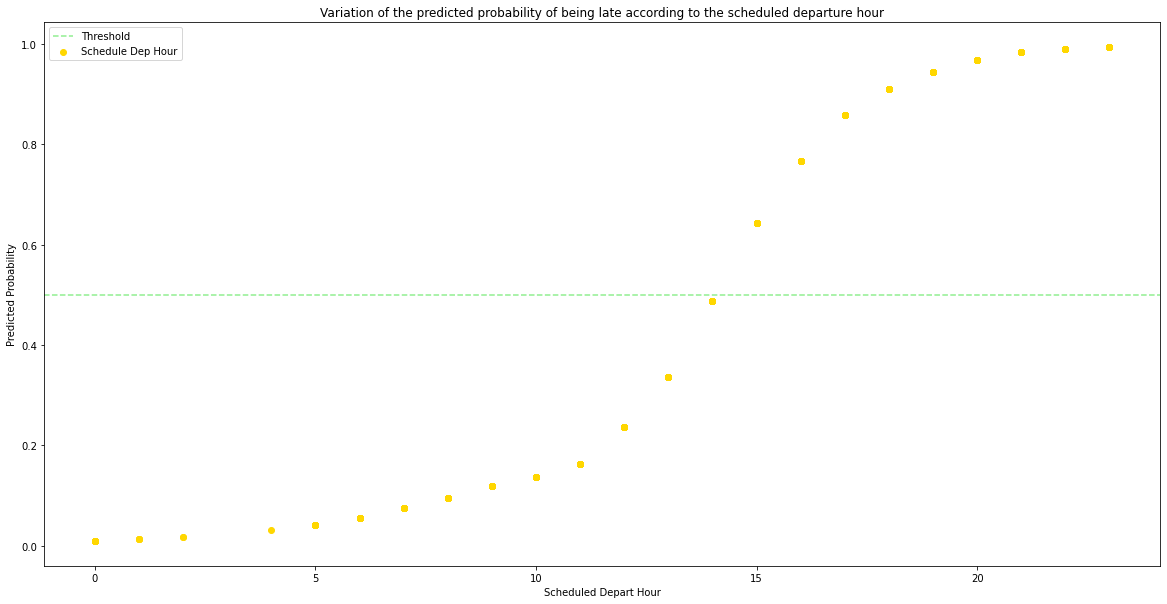

In [20]:
fig, ax = plt.subplots(1, figsize = (20, 10))
ax.scatter(constant_1['SCHED_DEP_HOUR'], predictions_sched_dep_hour, color='gold', label='Schedule Dep Hour')
ax.axhline(y=0.5, color='lightgreen',label='Threshold', linestyle='--')
ax.set_title('Variation of the predicted probability of being late according to the scheduled departure hour')
ax.set_xlabel('Scheduled Depart Hour')
ax.set_ylabel('Predicted Probability')
ax.legend(loc='best')
plt.show(fig)

**INTERPRETATION:**

According to the above plot, we may interpret some predictions as follows:
**When keeping everything constant to their mode/mean, scheduling the depart hour later increases the probability of the flight being delayed**. Statistically speaking, we are visualizing the marginal distribution of the the target conditionned on the Scheduled Depart Hour. However, beforehand, the neural network was trying to find the optimal parameters of the likelihood of the marginal distribution of y conditioned on **all of the features**. What we have done here is integrating over all the rest of the features, except *Scheduled Depart Hour*. 

Therefore, after having integrated over all of the other features, we can conclude that the predicitons of $y/x$ follow a clear trend: the flight will be delayed when the scheduled depart hour is after 16, and on time before. 

<a id="s142"></a>
<div class='exercise-r'>

**[1.4.2:](#q14)** Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `FLIGHT_COUNT` from the training set (see the question 1.4 "HINT" below).

**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your data points based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. Please refer to the matplotlib documentation for examples.

</div>

In [21]:
# your code here
constant_2 = pd.DataFrame()
for i, column in enumerate(X_train.columns):
    if column not in ['SCHED_DEP_HOUR', 'FLIGHT_COUNT']:
        if i < 7:
            constant_2[column] = X_train[column].mean()*np.ones(len(X_train[column]))
            
        else:
            constant_2[column] = 0*np.ones(len(X_train[column]))
    else:
        array = X_train[column].copy()
        constant_2[column]= X_train[column].values
scaled_constant_2 = Scaler.transform(constant_2)
predictions_sched_dep_hour = NN_model.predict(scaled_constant_2)

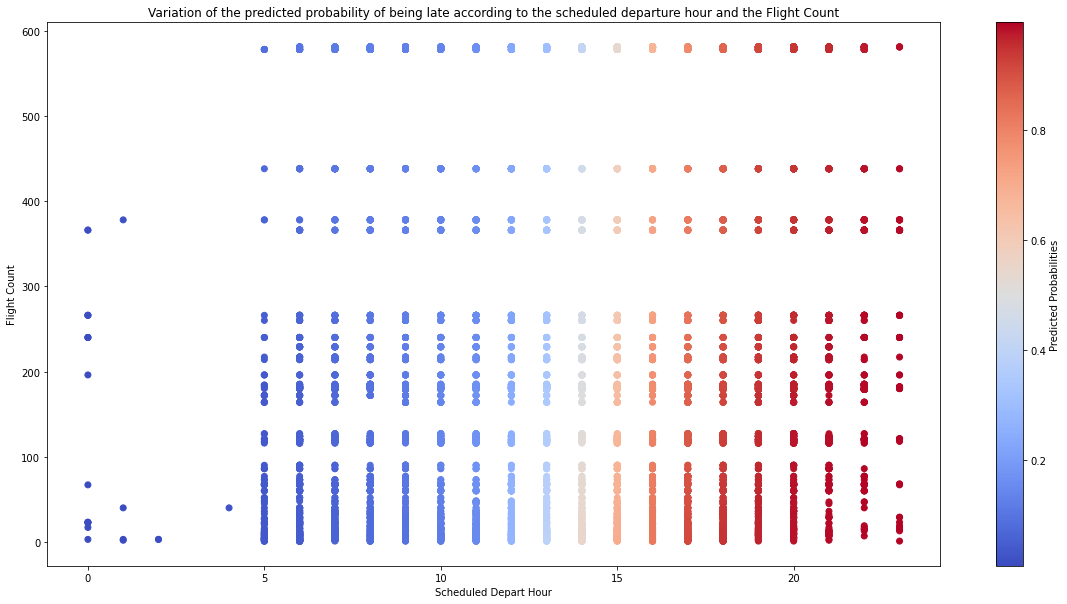

In [22]:
fig, ax = plt.subplots(1, figsize = (20, 10))
sc=ax.scatter(constant_2['SCHED_DEP_HOUR'], constant_2['FLIGHT_COUNT'], c=predictions_sched_dep_hour, cmap='coolwarm')
plt.colorbar(sc, label='Predicted Probabilities')
ax.set_title('Variation of the predicted probability of being late according to the scheduled departure hour and the Flight Count')
ax.set_xlabel('Scheduled Depart Hour')
ax.set_ylabel('Flight Count')
plt.show(fig)

This time, we have integrated over all of the features except two. Here, we are visualizing the predictions of $$y|Flightcount, SCHEDDEPHOUR = f(Flightcount, SCHEDDEPHOUR)$$

What we can see is that there is a pattern towards the lower right part of the graph. Therefore, higher number of fights increases the probability of not being late, and the correlation between Scheduled Depart Hour and Delay or Not has not been changed when considering the joint distribution (Flightcount, SCHEDDEPHOUR): the later a flight is scheduled, the more likely he is to be late. 

<a id="s143"></a>
<div class='exercise-r'>

**[1.4.3:](#q14)** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` from the training set.
    
</div>

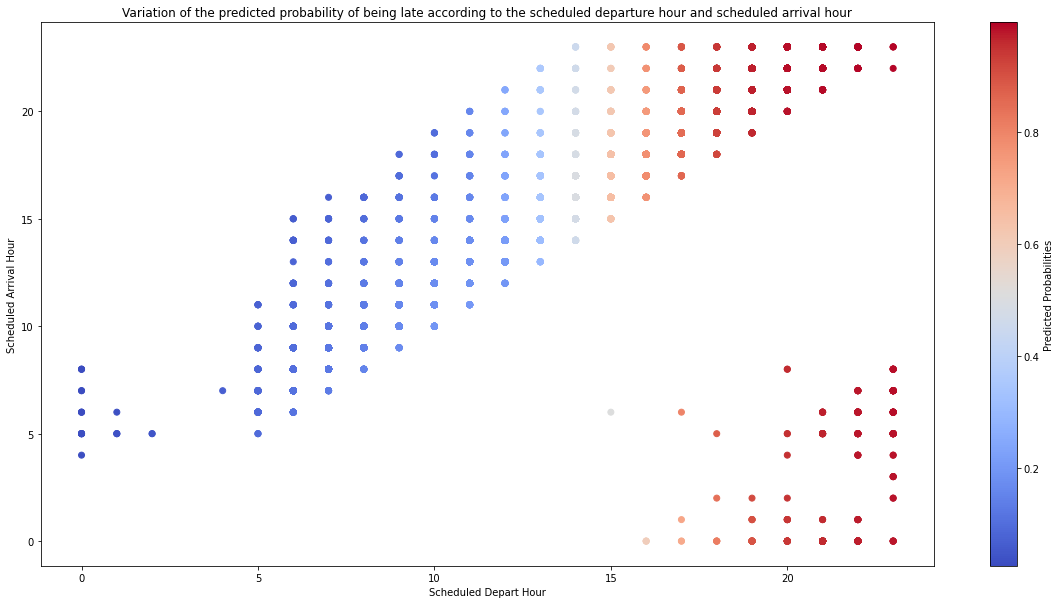

In [23]:
# your code here
constant_3 = pd.DataFrame()
for i, column in enumerate(X_train.columns):
    if column not in ['SCHED_DEP_HOUR', 'SCHED_ARR_HOUR']:
        if i < 7:
            constant_3[column] = X_train[column].mean()*np.ones(len(X_train[column]))
            
        else:
            constant_3[column] = 0*np.ones(len(X_train[column]))
    else:
        array = X_train[column].copy()
        constant_3[column]= X_train[column].values
scaled_constant_3 = Scaler.transform(constant_3)
predictions_sched_dep_hour = NN_model.predict(scaled_constant_3)
fig, ax = plt.subplots(1, figsize = (20, 10))
sc=ax.scatter(constant_3['SCHED_DEP_HOUR'], constant_3['SCHED_ARR_HOUR'], c=predictions_sched_dep_hour, cmap='coolwarm')
plt.colorbar(sc, label='Predicted Probabilities')
ax.set_title('Variation of the predicted probability of being late according to the scheduled departure hour and scheduled arrival hour')
ax.set_xlabel('Scheduled Depart Hour')
ax.set_ylabel('Scheduled Arrival Hour')
plt.show(fig)

As we can see here, once again we integrate over all the variables but 2. The two selected variables are Scheduled Depart Hour and Scheduled Arrival Hour. We can see that the correlation betwen Delay Or Not and Scheduled Depart Hour does not change either here when considering the joint distribution: the later a flight departs, the more likely he is to arrive late. Moreover, we can see a trend towards the upper right, meaning the the later a flight is scheduled to arrive, the more likely he is to be late. 

Now, we can suppose that this behhavior comes from the fact that *there is a high correlation between Scheduled Depart Hour and Scheduled Arrival Hour*, as is announced by the shape of the graph. 

<a id="s144"></a>
<div class='exercise-r'>

**[1.4.4:](#q14)** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `DISTANCE` from the training set.
    
</div>

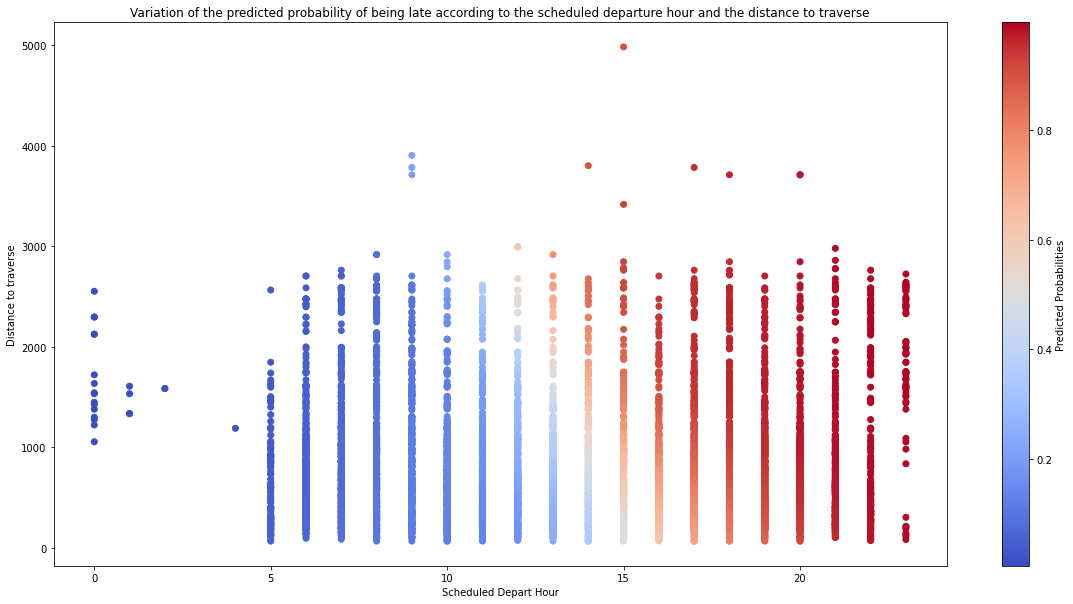

In [24]:
# your code here
constant_4 = pd.DataFrame()
for i, column in enumerate(X_train.columns):
    if column not in ['SCHED_DEP_HOUR', 'DISTANCE']:
        if i < 7:
            constant_4[column] = X_train[column].mean()*np.ones(len(X_train[column]))
            
        else:
            constant_4[column] = 0*np.ones(len(X_train[column]))
    else:
        array = X_train[column].copy()
        constant_4[column]= X_train[column].values
scaled_constant_4 = Scaler.transform(constant_4)
predictions_sched_dep_hour = NN_model.predict(scaled_constant_4)
fig, ax = plt.subplots(1, figsize = (20, 10))
sc=ax.scatter(constant_4['SCHED_DEP_HOUR'], constant_4['DISTANCE'], c=predictions_sched_dep_hour, cmap='coolwarm')
plt.colorbar(sc, label='Predicted Probabilities')
ax.set_title('Variation of the predicted probability of being late according to the scheduled departure hour and the distance to traverse')
ax.set_xlabel('Scheduled Depart Hour')
ax.set_ylabel('Distance to traverse')
plt.show(fig)

The distance to traverse has a positive correlation with the Delay Or Not. This can be explained by the fact that we have already seen that the later a flight is scheduled to arrive, the more likely he is to be late. Moreover, the bigger the distance to traverse, the later he will arrive and the highrt the Scheduled Arrival Hour. Therefore, I'm not sure that this plot brings a lot of information. 

<a id="s145"></a>
<div class='exercise-r'>

**[1.4.5:](#q14)** In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.
    
</div>

**INTERPRETATION:**

1. According to the first. plot, we may interpret some predictions as follows:
    **When keeping everything constant to their mode/mean, scheduling the depart hour later increases the probability of the flight being delayed**. Statistically speaking, we are visualizing the marginal distribution of the the target conditionned on the Scheduled Depart Hour. However, beforehand, the neural network was trying to find the optimal parameters of the likelihood of the marginal distribution of y conditioned on **all of the features**. What we have done here is integrating over all the rest of the features, except *Scheduled Depart Hour*. 

    Therefore, after having integrated over all of the other features, we can conclude that the predicitons of $y/x$ follow a clear trend: the flight will be delayed when the scheduled depart hour is after 16, and on time before. 
    
    
2. This time, we have integrated over all of the features except two. Here, we are visualizing the predictions $$y|Flightcount, SCHEDDEPHOUR = f(Flightcount, SCHEDDEPHOUR)$$

    What we can see is that there is a pattern towards the lower right part of the graph. Therefore, higher number of fights increases the probability of not being late, and the correlation between Scheduled Depart Hour and Delay or Not has not been changed when considering the joint distribution (Flightcount, SCHEDDEPHOUR): the later a flight is scheduled, the more likely he is to be late. 
    
    
3. As we can see here, once again we integrate over all the variables but 2. The two selected variables are Scheduled Depart Hour and Scheduled Arrival Hour. We can see that the correlation betwen Delay Or Not and Scheduled Depart Hour does not change either here when considering the joint distribution: the later a flight departs, the more likely he is to arrive late. Moreover, we can see a trend towards the upper right, meaning the the later a flight is scheduled to arrive, the more likely he is to be late. 

    Now, we can suppose that this behhavior comes from the fact that *there is a high correlation between Scheduled Depart Hour and Scheduled Arrival Hour*, as is announced by the shape of the graph. 
    
    
4. The distance to traverse has a positive correlation with the Delay Or Not. This can be explained by the fact that we have already seen that the later a flight is scheduled to arrive, the more likely he is to be late. Moreover, the bigger the distance to traverse, the later he will arrive and the highrt the Scheduled Arrival Hour. Therefore, I'm not sure that this plot brings a lot of information. 

<a id="s15"></a>
<div class='exercise-r'>

**[1.5:](#q15) Bootstrap prediction intervals**

In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (a minimum $n$ of at least 50 bootstraps should be used). Predict the output on the test data for each model. Randomly select 8 test observations and on 8 subplots, plot the distribution of predicted probabilities (i.e. $n$ bootstrapped probabilites) with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

</div>

In [25]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [26]:
%%time
# Bootstrap and train your networks and get predictions on X test
# your code here
n_bootstrap = 50
predictions = []
for i in range(n_bootstrap):
    resample_indexes = np.random.choice(range(len(X_train)), size = len(X_train), replace=True)
    X_train_bootstrapped = X_train_scaled[resample_indexes]
    y_train_bootstrapped = y_train.values[resample_indexes]
    dim_input = X_train_bootstrapped.shape[1]
    dim_output = 1 # binary classification
    NN_model = tf.keras.models.Sequential(name='NN_model')
    hidden_layers = 2  # depth
    width_hidden_layers = 15 
    NN_model.add((tf.keras.layers.Dense(width_hidden_layers,input_dim=dim_input, activation = 'relu',name='hidden1')))
    NN_model.add((tf.keras.layers.Dense(width_hidden_layers, activation = 'relu',name='hidden2')))
    NN_model.add(tf.keras.layers.Dense(dim_output, activation = 'sigmoid',name='output'))
    NN_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
    NN_model.fit(X_train_bootstrapped, y_train_bootstrapped, epochs=100, batch_size=64, verbose=0, validation_split=0.2)
    predictions_boot = NN_model.predict_proba(X_test_scaled)
    predictions.append(predictions_boot)

Instructions for updating:
Please use `model.predict()` instead.
Wall time: 12min 41s


In [27]:
predictions_array = np.array(predictions).reshape(50, 1999)

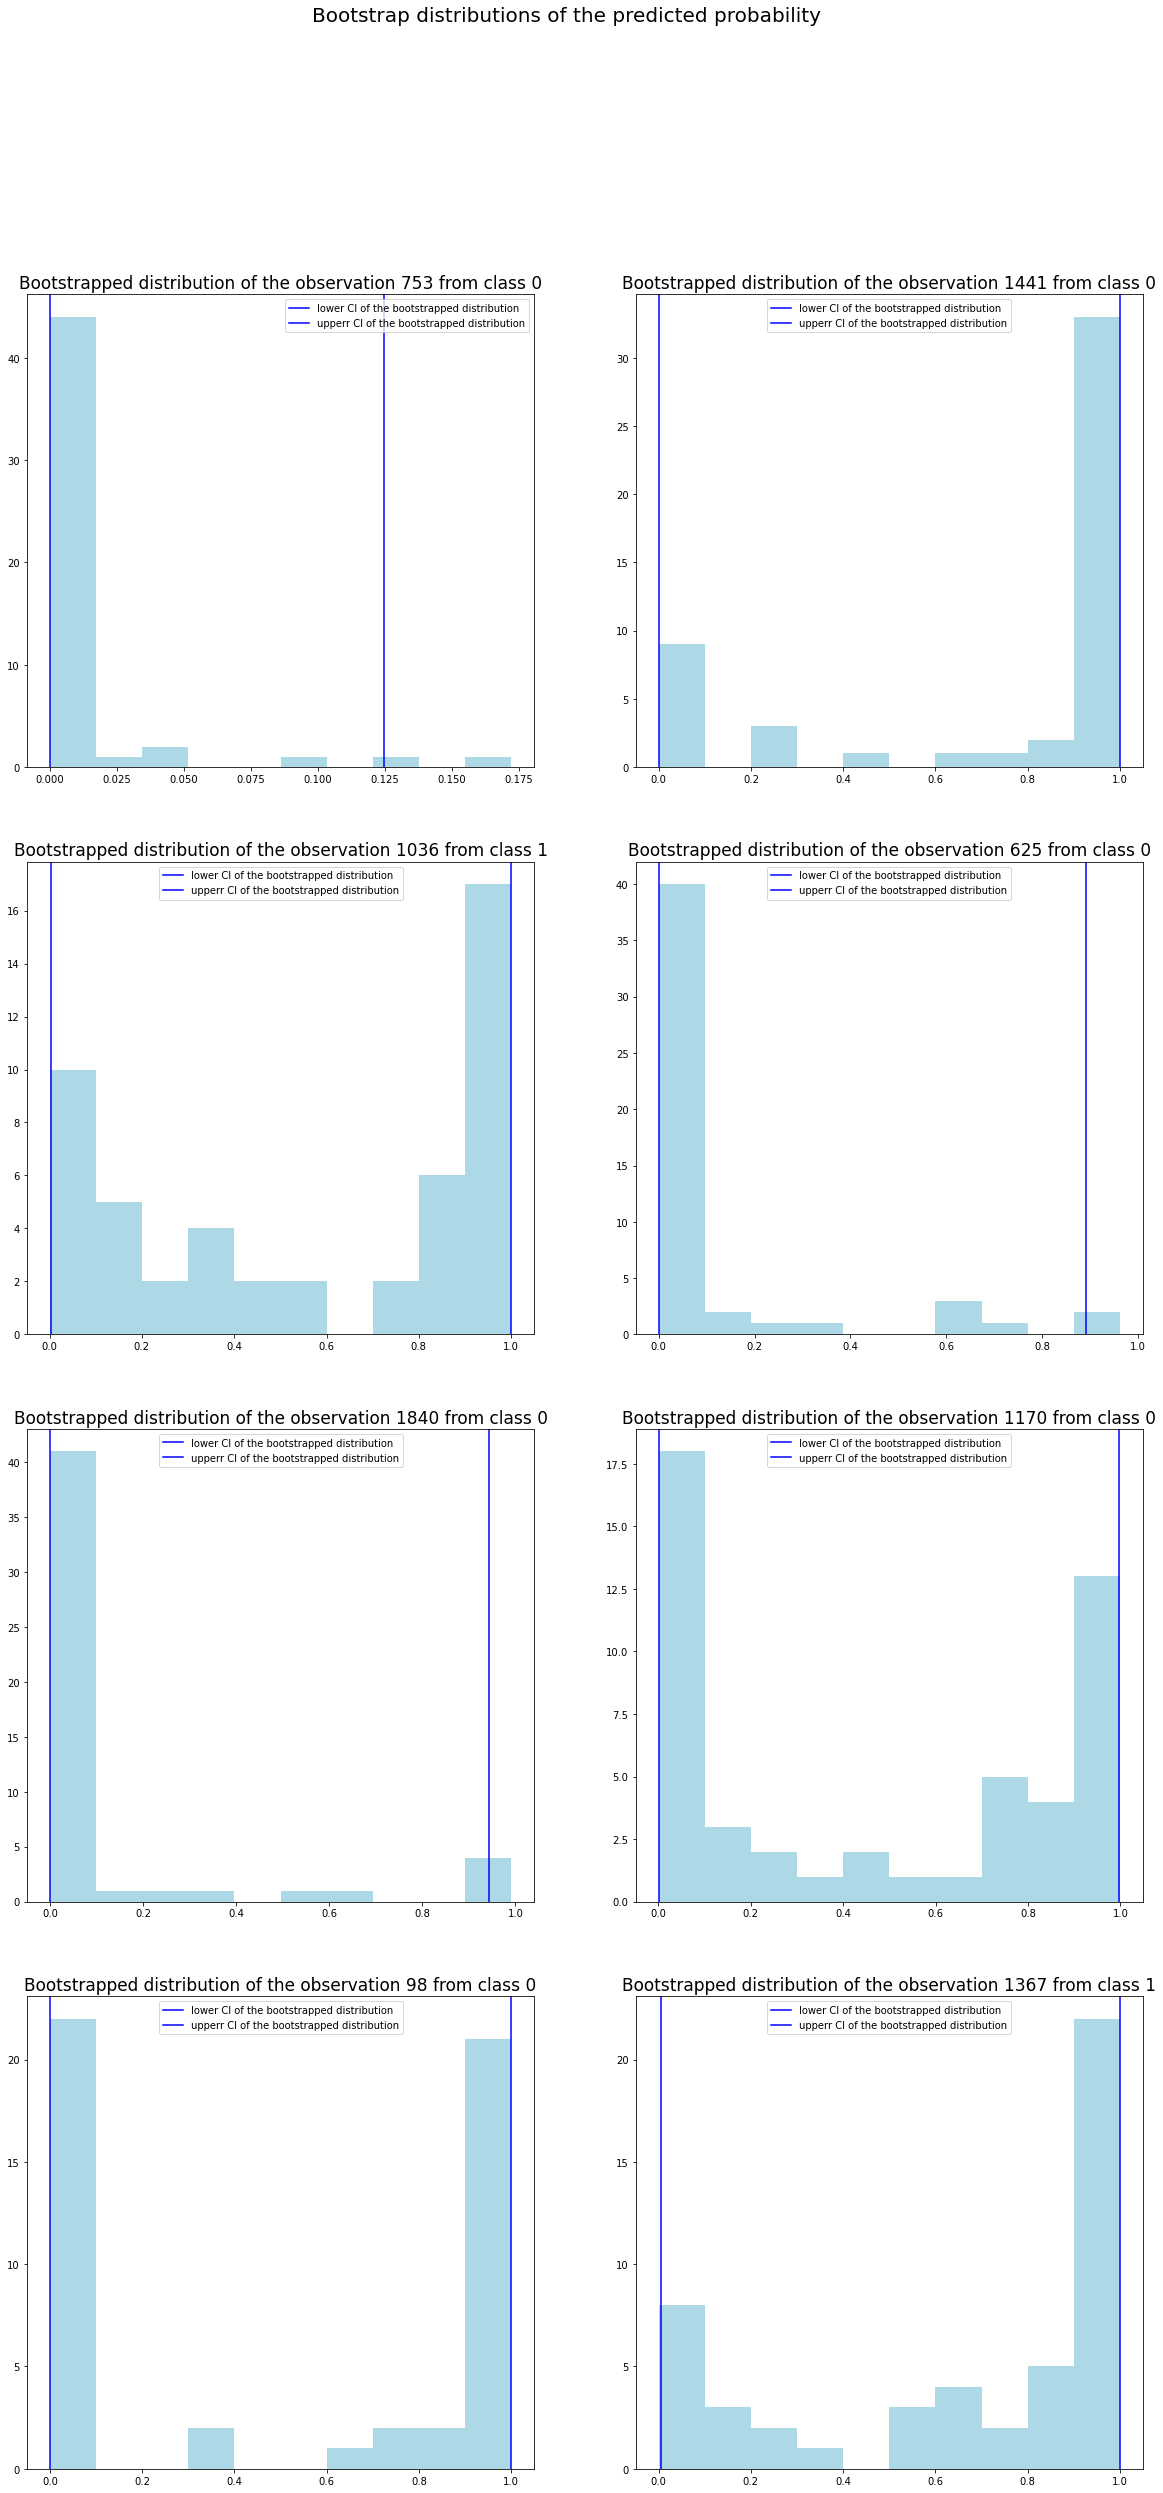

In [28]:
# generate your plot
# your code here
selected_observations = np.random.choice(range(predictions_array.shape[1]), size=8, replace=False)
fig, ax = plt.subplots(4, 2, figsize = (20, 40))
plt.suptitle('Bootstrap distributions of the predicted probability', size=20)
for i, ax in enumerate(ax.ravel()):
    idx = selected_observations[i]
    bootstrapped_proba = predictions_array[:, idx]
    lower_CI = np.percentile(bootstrapped_proba, 2.5)
    upper_CI = np.percentile(bootstrapped_proba, 97.5)
    ax.hist(bootstrapped_proba, color='lightblue', bins=10)
    ax.axvline(x=lower_CI, color='blue', label='lower CI of the bootstrapped distribution')
    ax.axvline(x=upper_CI, color='blue', label='upperr CI of the bootstrapped distribution')
    ax.set_title('Bootstrapped distribution of the observation ' + str(idx) + ' from class ' + str(y_test.values[idx]), size=17)
    ax.legend(loc='best')

**INTERPRETATION:**

We can see that, in our testing set, there are several kinds of testing points:
- Points for which our model is confident with its prediction: a large majority of the predictions from the different Neural Networks trained on the bootstrapped data predict a probability that is close to 0 or 1
- Points for which our model is not confident with its prediction. For instance, for the observation 1564, we can see that almost half of the bootstrapped models would predict the class 0 and the other half would predict class 1. 

This technique could be a means for us to estimate the **epistemic uncertainty** of our model, meaning how confident is our model when performing predictions. 

<a id="s16"></a>
<div class='exercise-r'>

**[1.6:](#q16) Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how "significant" our bagged (i.e. bootstrap-aggregated) prediction will be for each test observation.

To accomplish this, you will first calculate the ratio of bootstrapped probabilities that cross the threshold value of $\hat{p}=0.5$. Let's call this ratio the **Posterior Prediction Ratio (PPR)**. When a bagged prediction's $PPR=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPR=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPR$ values for all test observations, you should have $n=2000$ $PPR$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for significance (i.e. maximum $PPR$ value) is not met. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPR$ threshold). You can make your abstain model *stricter* by using smaller $PPR$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPR$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPR$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPR$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model predicts confidently. 

</div>

In [29]:
# your code here
PPR = np.mean(predictions_array > 0.5, axis=0)

In [30]:
bagging_predictions = 1*(PPR > 0.5)
accuracy_bagging = accuracy_score(y_test, bagging_predictions)
print('The test accuracy of the bagging model is ', accuracy_bagging)


The test accuracy of the bagging model is  0.6988494247123562


In [31]:
thresholds = np.linspace(0, 0.95, 20)
scores = []
numbers = []
for threshold in thresholds:
    mask = PPR > threshold
    predictors_selected = predictions_array[:, mask]
    test_selected = y_test[mask]
    bagging_predictions = 1*(np.mean(predictors_selected, axis=0)>0.5)
    accuracy_bagging = accuracy_score(test_selected, bagging_predictions)
    num_points = predictors_selected.shape[1]
    numbers.append(num_points)
    scores.append(accuracy_bagging)

In [32]:
numbers

[1933,
 1794,
 1673,
 1511,
 1389,
 1251,
 1121,
 1043,
 998,
 906,
 849,
 773,
 682,
 634,
 555,
 517,
 465,
 383,
 327,
 202]

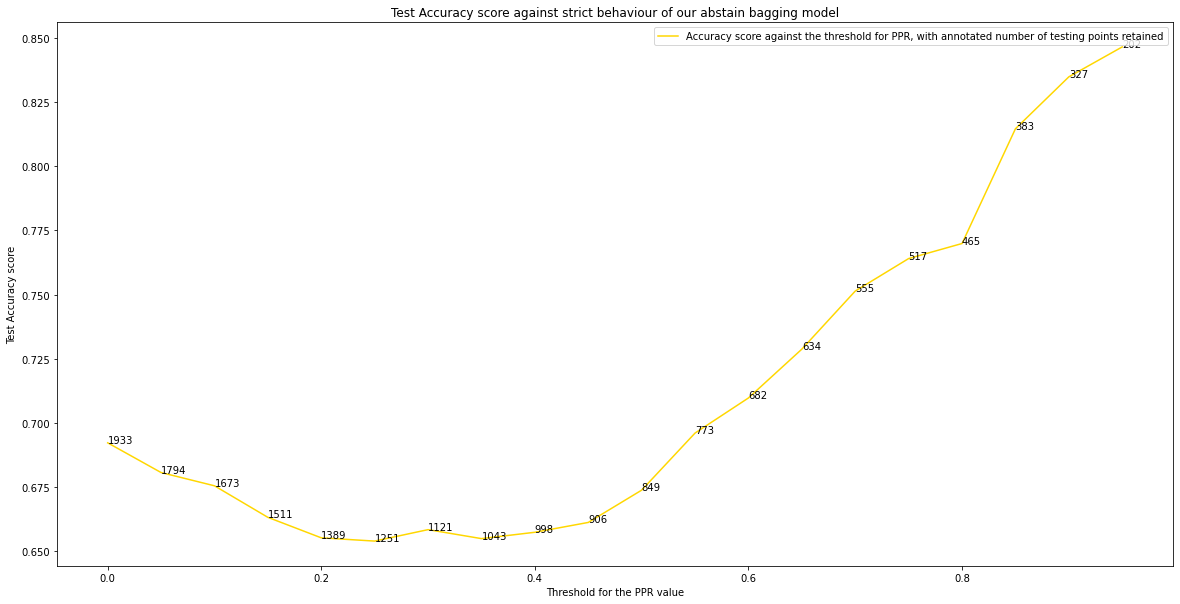

In [33]:
fig, ax = plt.subplots(1, figsize = (20, 10))
ax.plot(thresholds, scores, label='Accuracy score against the threshold for PPR, with annotated number of testing points retained', color='gold')
ax.set_xlabel('Threshold for the PPR value')
ax.set_ylabel('Test Accuracy score')
for i in range(len(thresholds)):
    ax.annotate(numbers[i], (thresholds[i], scores[i]))
ax.legend(loc='best')
ax.set_title('Test Accuracy score against strict behaviour of our abstain bagging model')
plt.show(fig)

**INTERPRETATION:**

Therefore, as we can see:
- As the threshold for PPR increases (we wish to make more confident predictions), we leverage less test points. 
- As the threshold for PPR increases, we select observations for which we are more confident making predictions, therefore the score increases (since we are more often right than wrong)
- We can see that our model is **not well calibrated**

<a id="part2"></a>

<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [35 pts]: Kannada MNIST Kaggle competition

[Return to contents](#contents)


<a id="part2intro"></a>

## Problem Statement

[Return to contents](#contents)


ANNs can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns do not generalize to new data.

There are several methods used to improve ANN generalization. 

One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization".

In this problem, you are asked to regularize a network of a given architecture.

<a id="part2about"></a>

## The Kannada MNIST Dataset

[Return to contents](#contents)


![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media)


For this problem, we will be working with a modified version of the [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf), which is a large database of handwritten digits in the indigenous language *Kannada*.

This dataset consists of 60,000 28x28 grayscale images of the ten digits, along with a test set of 10,000 images. 

For this homework, we will simplify the problem by only using the digits labeled `0` and `1` owing to the similarity of the two symbols, and we will use a total of 1,200 samples for training (this includes the data you will use for validation).

To understand the dataset better, we recommend this [article](https://towardsdatascience.com/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the curator of the dataset.

<a id="part2data"></a>

## Downloading the Data Files

[Return to contents](#contents)


**Please download the specific `kmnist_train.csv` and `kmnist_test.csv` data files available on [the "Data" tab of the CS109A HW7 Kaggle Competition website](https://www.kaggle.com/t/a361e7630e424da9abb12703c782a0c7). (DO NOT USE DATA FROM ANY OTHER SOURCE!)**

Here's a brief description of the data files:

- `kmnist_train.csv` is our training dataset and the last column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image. Class 0 means a sample is the handwritten digit `0` and class 1 means a sample is the handwritten digit `1` in the Kannada written language. `kmnist_train.csv` has 1,200 samples.


- `kmnist_test.csv` has a structure similar to `kmnist_train.csv`, however the class label column is NOT included in with the test set. `kmnist_test.csv` has 2,000 samples. 


Kaggle leaderboard scores are accuracy scores calculated by Kaggle when you upload your predictions on this test set.

- `sample_submission.csv` is the format that kaggle will accept. The uploaded `.csv` must contain 2 columns. The first column must be named `id` and needs to contain the test observation index numbers for each prediction, the second must be named `category` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. 

<a id="part2kaggle"></a>

## CS109A Kaggle Competition

[Return to contents](#contents)

**ACCESS AND JOIN THE COMPETITION**:

**You need to create an account on Kaggle and [join the competition via this link](https://www.kaggle.com/t/a361e7630e424da9abb12703c782a0c7). This is a limited participation competition. Please DO NOT share this link.**

**For more information on the rules** governing this CS109A Kaggle competition, please see below and also review [the modelling restrictions DOS and DON'TS outlined in question 2.3](#q23).

**IMPORTANT NOTES ABOUT SCORING**:

- The **public leaderboard** on Kaggle displays your performance on only 50% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the remaining 50% of the test set.


Only the **Top-25** competitors (as ranked on the hidden private leaderboard) will be eligible for full credit on [question 2.3](#q23) (out of **25 points**). Those in the **Top-50**, but not the **Top-25**, will be scored out of **24 points** on question 2.3. Those in the **Top-75**, but not **Top-50**, will be scored out of **23 points**. Those in the **Top-100**, but not **Top-75**, will be scored out of **22 points**. Those in the **Top-125**, but not **Top-100**, will be scored out of **21 points**. All remaining competitors will be scored out of **20 points only** for 2.3. (**NOTE:** additional points may still be deducted on question 2.3 for other non-score-related errors)

**BONUS:** An additional **5 bonus points** will be given to the **Top-3** competitors (as ranked on the hidden private leaderboard).

**ADDITIONAL COMPETITION RULES:**

- Multiple Kaggle submissions are permitted (with a maximum of 20 submissions per-participant per-day), **just note that you will need to choose, on Kaggle, the ONE single submission to use for final scoring prior to the final HW7 submission deadline**, and **your submitted notebook MUST contain the matching code and model that generated your ONE chosen submission.**


- **To repeat this point, the version of your final HW7 notebook submitted on Canvas MUST contain the same code and exact same model used to generate your ONE chosen Kaggle submission.** (TFs may rerun your notebook code to ensure comparable final leaderboard results.)


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, you MUST USE ONLY the KMNIST training and test data downloaded via the "Data" tab of [the CS109A competition page linked above](#part2data).**


- **Do not** create multiple accounts on Kaggle.


<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

<a id="part2questions"></a>

## <div class='exercise'>PART2 Questions</div>

[Return to contents](#contents)


<a id="q21"></a>

**[2.1:](#s21) Get and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1 from the training set.

<a id="q22"></a>

**[2.2:](#s22) Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 1,000
- Batch size: 128
- Validation size: 0.3

![diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 

<a id="q23"></a>

**[2.3:](#s23) Regularize the overfit network**

Create an ANN that doesn't overfit and use it to [compete on Kaggle](#part2kaggle).

**DON'TS**

- **DO NOT change the architecture**. In other words, keep the same number of layers, same number of nodes, same activation function, and same loss function and output unit as was used in your question 2.2 overfit model. **No CNNs/RNNs/enhancements.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific KMNIST datasets provided to you (via the CS109A [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model (e.g., dropout, L2 norm, etc.).
 - **YOU CAN also** do data augmentation using the provided training data. 

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**

- **[2.3.1:](#s231)** Build and train your regularized model (you MUST adhere to the "DOS" and "DON'TS" listed above), print your model summary, and print your final training and validation accuracy and loss.


- **[2.3.2:](#s232)** Plot your model's training accuracy and validation accuracy as a function of epochs.


- **[2.3.3:](#s233)** In several sentences, describe the approach you have taken to improve the performance of your regularized model in 2.3.1 and any observations you might have regarding your training and Kaggle results.


- **[2.3.4:](#s234)** Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS109A Kaggle Competition](#part2kaggle) for leaderboard scoring. **IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"id"` and needs to contain the test observation index numbers corresponding to each of your 2,000 predictions, the second must be named `"category"` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. 


- **[2.3.5:](#s235)** **Specify your Kaggle name that you have used on the leaderboard**. We CAN NOT give you credit without this.

<a id="part2solutions"></a>

## PART 2 Solutions

[Return to contents](#contents)


<a id="s21"></a>

<div class='exercise-r'>

**[2.1:](#q21) Get and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1 from the training set.


</div>

In [34]:
# your code here
training_images = pd.read_csv('data/kmnist_train.csv')
testing_images = pd.read_csv('data/kmnist_test.csv')
training_images.head(5)

,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,pixel 10,...,pixel 776,pixel 777,pixel 778,pixel 779,pixel 780,pixel 781,pixel 782,pixel 783,pixel 784,output
0,56.514675,24.749116,15.420758,68.951633,13.760997,13.309949,68.951633,68.951633,13.309949,68.951633,...,31.413656,13.309949,23.733776,13.309949,13.309949,13.309949,68.951633,32.487911,13.309949,1
1,13.122449,13.122449,13.122449,13.122449,13.122449,13.122449,43.090392,15.339362,13.122449,13.122449,...,13.122449,13.122449,13.122449,24.566333,13.122449,13.122449,13.122449,13.409452,13.122449,1
2,56.228990,38.733386,43.356041,30.350765,30.350765,101.791573,30.350765,30.350765,101.791573,56.951487,...,30.350765,30.350765,30.350765,30.350765,30.350765,30.350765,50.652863,101.791573,30.350765,0
3,67.072705,33.257721,51.330661,17.868622,17.868622,17.868622,17.868622,17.868622,17.868622,17.868622,...,73.689417,17.868622,17.868622,17.868622,17.868622,17.868622,17.868622,17.868622,17.868622,0
4,17.867347,17.867347,17.867347,28.235052,17.867347,17.867347,17.867347,53.074296,43.465014,17.867347,...,17.867347,28.893451,17.867347,17.867347,17.867347,17.867347,62.989647,17.867347,17.867347,0


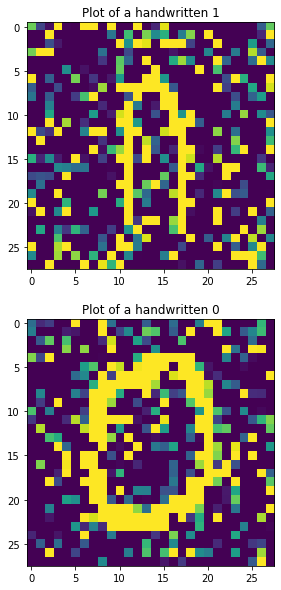

In [35]:
table1 = training_images[training_images['output']==1].iloc[0].values[:-1].reshape(28, 28)
table2 = training_images[training_images['output']==0].iloc[0].values[:-1].reshape(28, 28)
fig, ax = plt.subplots(2, figsize = (20, 10))
ax[0].imshow(table1)
ax[0].set_title('Plot of a handwritten 1')
ax[1].imshow(table2)
ax[1].set_title('Plot of a handwritten 0')
plt.show(fig)

<a id="s22"></a>

<div class='exercise-r'>

**[2.2:](#q22) Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 1,000
- Batch size: 128
- Validation size: 0.3

![diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting.
    
</div>

In [36]:
X = training_images.drop('output', axis=1)/255  
y = training_images['output']

In [37]:
# your code here
dim_input = X.shape[1]
dim_output = 1 # binary classification
NN_model = tf.keras.models.Sequential(name='NN_model')
hidden_layers = 3  # depth
width_hidden_layers = 100
NN_model.add((tf.keras.layers.Dense(width_hidden_layers,input_dim=dim_input, activation = 'relu',name='hidden1')))
NN_model.add((tf.keras.layers.Dense(width_hidden_layers, activation = 'relu',name='hidden2')))
NN_model.add((tf.keras.layers.Dense(width_hidden_layers, activation = 'relu',name='hidden3')))
NN_model.add(tf.keras.layers.Dense(dim_output, activation = 'sigmoid',name='output'))
NN_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
history = NN_model.fit(X, y, epochs=1000, batch_size=128, verbose=1, validation_split=0.3)

Epoch 1/1000
7/7 [==============================] - 0s 32ms/step - loss: 0.6735 - accuracy: 0.5405 - val_loss: 0.6450 - val_accuracy: 0.8333
Epoch 2/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.6139 - accuracy: 0.6488 - val_loss: 0.5806 - val_accuracy: 0.8139
Epoch 3/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.5480 - accuracy: 0.7690 - val_loss: 0.5123 - val_accuracy: 0.8056
Epoch 4/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.4407 - accuracy: 0.8774 - val_loss: 0.3782 - val_accuracy: 0.9167
Epoch 5/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.3381 - accuracy: 0.9155 - val_loss: 0.2829 - val_accuracy: 0.9250
Epoch 6/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2583 - accuracy: 0.9310 - val_loss: 0.2226 - val_accuracy: 0.9472
Epoch 7/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1956 - accuracy: 0.9405 - val_loss: 0.1872 - val_accuracy: 0.9361
Epoch 8/1000
7/7 [=

7/7 [==============================] - 0s 5ms/step - loss: 3.0688e-04 - accuracy: 1.0000 - val_loss: 0.2418 - val_accuracy: 0.9361
Epoch 59/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.9290e-04 - accuracy: 1.0000 - val_loss: 0.2430 - val_accuracy: 0.9361
Epoch 60/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.8303e-04 - accuracy: 1.0000 - val_loss: 0.2435 - val_accuracy: 0.9361
Epoch 61/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.7024e-04 - accuracy: 1.0000 - val_loss: 0.2450 - val_accuracy: 0.9361
Epoch 62/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.5812e-04 - accuracy: 1.0000 - val_loss: 0.2462 - val_accuracy: 0.9361
Epoch 63/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.4663e-04 - accuracy: 1.0000 - val_loss: 0.2478 - val_accuracy: 0.9361
Epoch 64/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.3797e-04 - accuracy: 1.0000 - val_loss: 0.2480 - val_accuracy: 0.9361

7/7 [==============================] - 0s 6ms/step - loss: 5.5778e-05 - accuracy: 1.0000 - val_loss: 0.2876 - val_accuracy: 0.9361
Epoch 115/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.4621e-05 - accuracy: 1.0000 - val_loss: 0.2880 - val_accuracy: 0.9361
Epoch 116/1000
7/7 [==============================] - 0s 5ms/step - loss: 5.3457e-05 - accuracy: 1.0000 - val_loss: 0.2893 - val_accuracy: 0.9389
Epoch 117/1000
7/7 [==============================] - 0s 5ms/step - loss: 5.2360e-05 - accuracy: 1.0000 - val_loss: 0.2890 - val_accuracy: 0.9361
Epoch 118/1000
7/7 [==============================] - 0s 5ms/step - loss: 5.1265e-05 - accuracy: 1.0000 - val_loss: 0.2902 - val_accuracy: 0.9361
Epoch 119/1000
7/7 [==============================] - 0s 5ms/step - loss: 5.0278e-05 - accuracy: 1.0000 - val_loss: 0.2905 - val_accuracy: 0.9361
Epoch 120/1000
7/7 [==============================] - 0s 5ms/step - loss: 4.9257e-05 - accuracy: 1.0000 - val_loss: 0.2910 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 2.1542e-05 - accuracy: 1.0000 - val_loss: 0.3140 - val_accuracy: 0.9389
Epoch 171/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.1274e-05 - accuracy: 1.0000 - val_loss: 0.3144 - val_accuracy: 0.9389
Epoch 172/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.0974e-05 - accuracy: 1.0000 - val_loss: 0.3148 - val_accuracy: 0.9389
Epoch 173/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.0758e-05 - accuracy: 1.0000 - val_loss: 0.3152 - val_accuracy: 0.9389
Epoch 174/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.0446e-05 - accuracy: 1.0000 - val_loss: 0.3156 - val_accuracy: 0.9389
Epoch 175/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.0175e-05 - accuracy: 1.0000 - val_loss: 0.3160 - val_accuracy: 0.9389
Epoch 176/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.9878e-05 - accuracy: 1.0000 - val_loss: 0.3162 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 1.1008e-05 - accuracy: 1.0000 - val_loss: 0.3330 - val_accuracy: 0.9389
Epoch 227/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0896e-05 - accuracy: 1.0000 - val_loss: 0.3334 - val_accuracy: 0.9389
Epoch 228/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0789e-05 - accuracy: 1.0000 - val_loss: 0.3336 - val_accuracy: 0.9389
Epoch 229/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0673e-05 - accuracy: 1.0000 - val_loss: 0.3339 - val_accuracy: 0.9389
Epoch 230/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0557e-05 - accuracy: 1.0000 - val_loss: 0.3341 - val_accuracy: 0.9389
Epoch 231/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0464e-05 - accuracy: 1.0000 - val_loss: 0.3344 - val_accuracy: 0.9389
Epoch 232/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0337e-05 - accuracy: 1.0000 - val_loss: 0.3346 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 6.4589e-06 - accuracy: 1.0000 - val_loss: 0.3482 - val_accuracy: 0.9389
Epoch 283/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.4000e-06 - accuracy: 1.0000 - val_loss: 0.3485 - val_accuracy: 0.9389
Epoch 284/1000
7/7 [==============================] - 0s 5ms/step - loss: 6.3462e-06 - accuracy: 1.0000 - val_loss: 0.3487 - val_accuracy: 0.9389
Epoch 285/1000
7/7 [==============================] - 0s 5ms/step - loss: 6.2968e-06 - accuracy: 1.0000 - val_loss: 0.3488 - val_accuracy: 0.9389
Epoch 286/1000
7/7 [==============================] - 0s 5ms/step - loss: 6.2399e-06 - accuracy: 1.0000 - val_loss: 0.3492 - val_accuracy: 0.9389
Epoch 287/1000
7/7 [==============================] - 0s 5ms/step - loss: 6.1888e-06 - accuracy: 1.0000 - val_loss: 0.3492 - val_accuracy: 0.9389
Epoch 288/1000
7/7 [==============================] - 0s 5ms/step - loss: 6.1314e-06 - accuracy: 1.0000 - val_loss: 0.3495 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 4.1078e-06 - accuracy: 1.0000 - val_loss: 0.3611 - val_accuracy: 0.9389
Epoch 339/1000
7/7 [==============================] - 0s 5ms/step - loss: 4.0851e-06 - accuracy: 1.0000 - val_loss: 0.3614 - val_accuracy: 0.9389
Epoch 340/1000
7/7 [==============================] - 0s 5ms/step - loss: 4.0505e-06 - accuracy: 1.0000 - val_loss: 0.3614 - val_accuracy: 0.9389
Epoch 341/1000
7/7 [==============================] - 0s 5ms/step - loss: 4.0188e-06 - accuracy: 1.0000 - val_loss: 0.3618 - val_accuracy: 0.9389
Epoch 342/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.9933e-06 - accuracy: 1.0000 - val_loss: 0.3619 - val_accuracy: 0.9389
Epoch 343/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.9564e-06 - accuracy: 1.0000 - val_loss: 0.3623 - val_accuracy: 0.9389
Epoch 344/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.9286e-06 - accuracy: 1.0000 - val_loss: 0.3623 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 2.7650e-06 - accuracy: 1.0000 - val_loss: 0.3725 - val_accuracy: 0.9389
Epoch 395/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.7462e-06 - accuracy: 1.0000 - val_loss: 0.3727 - val_accuracy: 0.9389
Epoch 396/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.7278e-06 - accuracy: 1.0000 - val_loss: 0.3729 - val_accuracy: 0.9389
Epoch 397/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.7095e-06 - accuracy: 1.0000 - val_loss: 0.3730 - val_accuracy: 0.9389
Epoch 398/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.6920e-06 - accuracy: 1.0000 - val_loss: 0.3733 - val_accuracy: 0.9389
Epoch 399/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.6769e-06 - accuracy: 1.0000 - val_loss: 0.3734 - val_accuracy: 0.9389
Epoch 400/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.6604e-06 - accuracy: 1.0000 - val_loss: 0.3735 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 1.9358e-06 - accuracy: 1.0000 - val_loss: 0.3828 - val_accuracy: 0.9389
Epoch 451/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.9238e-06 - accuracy: 1.0000 - val_loss: 0.3829 - val_accuracy: 0.9389
Epoch 452/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.9108e-06 - accuracy: 1.0000 - val_loss: 0.3830 - val_accuracy: 0.9389
Epoch 453/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.9008e-06 - accuracy: 1.0000 - val_loss: 0.3833 - val_accuracy: 0.9389
Epoch 454/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.8866e-06 - accuracy: 1.0000 - val_loss: 0.3834 - val_accuracy: 0.9389
Epoch 455/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.8757e-06 - accuracy: 1.0000 - val_loss: 0.3836 - val_accuracy: 0.9389
Epoch 456/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.8650e-06 - accuracy: 1.0000 - val_loss: 0.3837 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 1.3913e-06 - accuracy: 1.0000 - val_loss: 0.3922 - val_accuracy: 0.9389
Epoch 507/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.3831e-06 - accuracy: 1.0000 - val_loss: 0.3923 - val_accuracy: 0.9389
Epoch 508/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.3767e-06 - accuracy: 1.0000 - val_loss: 0.3927 - val_accuracy: 0.9389
Epoch 509/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.3676e-06 - accuracy: 1.0000 - val_loss: 0.3926 - val_accuracy: 0.9389
Epoch 510/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.3599e-06 - accuracy: 1.0000 - val_loss: 0.3930 - val_accuracy: 0.9389
Epoch 511/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.3527e-06 - accuracy: 1.0000 - val_loss: 0.3931 - val_accuracy: 0.9389
Epoch 512/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.3443e-06 - accuracy: 1.0000 - val_loss: 0.3933 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 1.0218e-06 - accuracy: 1.0000 - val_loss: 0.4012 - val_accuracy: 0.9389
Epoch 563/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0160e-06 - accuracy: 1.0000 - val_loss: 0.4013 - val_accuracy: 0.9389
Epoch 564/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.0104e-06 - accuracy: 1.0000 - val_loss: 0.4014 - val_accuracy: 0.9389
Epoch 565/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0052e-06 - accuracy: 1.0000 - val_loss: 0.4016 - val_accuracy: 0.9389
Epoch 566/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0002e-06 - accuracy: 1.0000 - val_loss: 0.4018 - val_accuracy: 0.9389
Epoch 567/1000
7/7 [==============================] - 0s 5ms/step - loss: 9.9530e-07 - accuracy: 1.0000 - val_loss: 0.4020 - val_accuracy: 0.9389
Epoch 568/1000
7/7 [==============================] - 0s 5ms/step - loss: 9.8915e-07 - accuracy: 1.0000 - val_loss: 0.4021 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 7.6239e-07 - accuracy: 1.0000 - val_loss: 0.4096 - val_accuracy: 0.9389
Epoch 619/1000
7/7 [==============================] - 0s 5ms/step - loss: 7.5969e-07 - accuracy: 1.0000 - val_loss: 0.4098 - val_accuracy: 0.9389
Epoch 620/1000
7/7 [==============================] - 0s 5ms/step - loss: 7.5504e-07 - accuracy: 1.0000 - val_loss: 0.4098 - val_accuracy: 0.9389
Epoch 621/1000
7/7 [==============================] - 0s 5ms/step - loss: 7.5065e-07 - accuracy: 1.0000 - val_loss: 0.4101 - val_accuracy: 0.9389
Epoch 622/1000
7/7 [==============================] - 0s 5ms/step - loss: 7.4858e-07 - accuracy: 1.0000 - val_loss: 0.4103 - val_accuracy: 0.9389
Epoch 623/1000
7/7 [==============================] - 0s 5ms/step - loss: 7.4386e-07 - accuracy: 1.0000 - val_loss: 0.4103 - val_accuracy: 0.9389
Epoch 624/1000
7/7 [==============================] - 0s 5ms/step - loss: 7.3996e-07 - accuracy: 1.0000 - val_loss: 0.4106 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 5.7687e-07 - accuracy: 1.0000 - val_loss: 0.4176 - val_accuracy: 0.9389
Epoch 675/1000
7/7 [==============================] - 0s 5ms/step - loss: 5.7358e-07 - accuracy: 1.0000 - val_loss: 0.4179 - val_accuracy: 0.9389
Epoch 676/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.7126e-07 - accuracy: 1.0000 - val_loss: 0.4180 - val_accuracy: 0.9389
Epoch 677/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.6850e-07 - accuracy: 1.0000 - val_loss: 0.4181 - val_accuracy: 0.9389
Epoch 678/1000
7/7 [==============================] - 0s 7ms/step - loss: 5.6589e-07 - accuracy: 1.0000 - val_loss: 0.4182 - val_accuracy: 0.9389
Epoch 679/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.6320e-07 - accuracy: 1.0000 - val_loss: 0.4182 - val_accuracy: 0.9361
Epoch 680/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.6025e-07 - accuracy: 1.0000 - val_loss: 0.4185 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 4.4090e-07 - accuracy: 1.0000 - val_loss: 0.4254 - val_accuracy: 0.9389
Epoch 731/1000
7/7 [==============================] - 0s 5ms/step - loss: 4.3887e-07 - accuracy: 1.0000 - val_loss: 0.4255 - val_accuracy: 0.9389
Epoch 732/1000
7/7 [==============================] - 0s 5ms/step - loss: 4.3649e-07 - accuracy: 1.0000 - val_loss: 0.4257 - val_accuracy: 0.9389
Epoch 733/1000
7/7 [==============================] - 0s 5ms/step - loss: 4.3472e-07 - accuracy: 1.0000 - val_loss: 0.4258 - val_accuracy: 0.9389
Epoch 734/1000
7/7 [==============================] - 0s 5ms/step - loss: 4.3238e-07 - accuracy: 1.0000 - val_loss: 0.4260 - val_accuracy: 0.9389
Epoch 735/1000
7/7 [==============================] - 0s 5ms/step - loss: 4.3035e-07 - accuracy: 1.0000 - val_loss: 0.4261 - val_accuracy: 0.9389
Epoch 736/1000
7/7 [==============================] - 0s 5ms/step - loss: 4.2888e-07 - accuracy: 1.0000 - val_loss: 0.4264 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 3.3942e-07 - accuracy: 1.0000 - val_loss: 0.4330 - val_accuracy: 0.9389
Epoch 787/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.3800e-07 - accuracy: 1.0000 - val_loss: 0.4331 - val_accuracy: 0.9389
Epoch 788/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.3652e-07 - accuracy: 1.0000 - val_loss: 0.4333 - val_accuracy: 0.9389
Epoch 789/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.3479e-07 - accuracy: 1.0000 - val_loss: 0.4334 - val_accuracy: 0.9389
Epoch 790/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.3316e-07 - accuracy: 1.0000 - val_loss: 0.4336 - val_accuracy: 0.9389
Epoch 791/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.3152e-07 - accuracy: 1.0000 - val_loss: 0.4337 - val_accuracy: 0.9389
Epoch 792/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.3019e-07 - accuracy: 1.0000 - val_loss: 0.4338 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 2.5558e-07 - accuracy: 1.0000 - val_loss: 0.4412 - val_accuracy: 0.9333
Epoch 843/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.5430e-07 - accuracy: 1.0000 - val_loss: 0.4414 - val_accuracy: 0.9333
Epoch 844/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.5267e-07 - accuracy: 1.0000 - val_loss: 0.4415 - val_accuracy: 0.9333
Epoch 845/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.5132e-07 - accuracy: 1.0000 - val_loss: 0.4417 - val_accuracy: 0.9333
Epoch 846/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.4986e-07 - accuracy: 1.0000 - val_loss: 0.4419 - val_accuracy: 0.9333
Epoch 847/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.4861e-07 - accuracy: 1.0000 - val_loss: 0.4419 - val_accuracy: 0.9333
Epoch 848/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.4696e-07 - accuracy: 1.0000 - val_loss: 0.4423 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 1.7604e-07 - accuracy: 1.0000 - val_loss: 0.4518 - val_accuracy: 0.9333
Epoch 899/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.7468e-07 - accuracy: 1.0000 - val_loss: 0.4521 - val_accuracy: 0.9333
Epoch 900/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.7336e-07 - accuracy: 1.0000 - val_loss: 0.4523 - val_accuracy: 0.9333
Epoch 901/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.7201e-07 - accuracy: 1.0000 - val_loss: 0.4526 - val_accuracy: 0.9333
Epoch 902/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.7043e-07 - accuracy: 1.0000 - val_loss: 0.4527 - val_accuracy: 0.9333
Epoch 903/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.6921e-07 - accuracy: 1.0000 - val_loss: 0.4530 - val_accuracy: 0.9333
Epoch 904/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.6778e-07 - accuracy: 1.0000 - val_loss: 0.4532 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 1.0733e-07 - accuracy: 1.0000 - val_loss: 0.4660 - val_accuracy: 0.9333
Epoch 955/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.0645e-07 - accuracy: 1.0000 - val_loss: 0.4661 - val_accuracy: 0.9333
Epoch 956/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0536e-07 - accuracy: 1.0000 - val_loss: 0.4664 - val_accuracy: 0.9333
Epoch 957/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0442e-07 - accuracy: 1.0000 - val_loss: 0.4667 - val_accuracy: 0.9333
Epoch 958/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0345e-07 - accuracy: 1.0000 - val_loss: 0.4669 - val_accuracy: 0.9333
Epoch 959/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0245e-07 - accuracy: 1.0000 - val_loss: 0.4672 - val_accuracy: 0.9333
Epoch 960/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.0160e-07 - accuracy: 1.0000 - val_loss: 0.4675 - val_accuracy: 

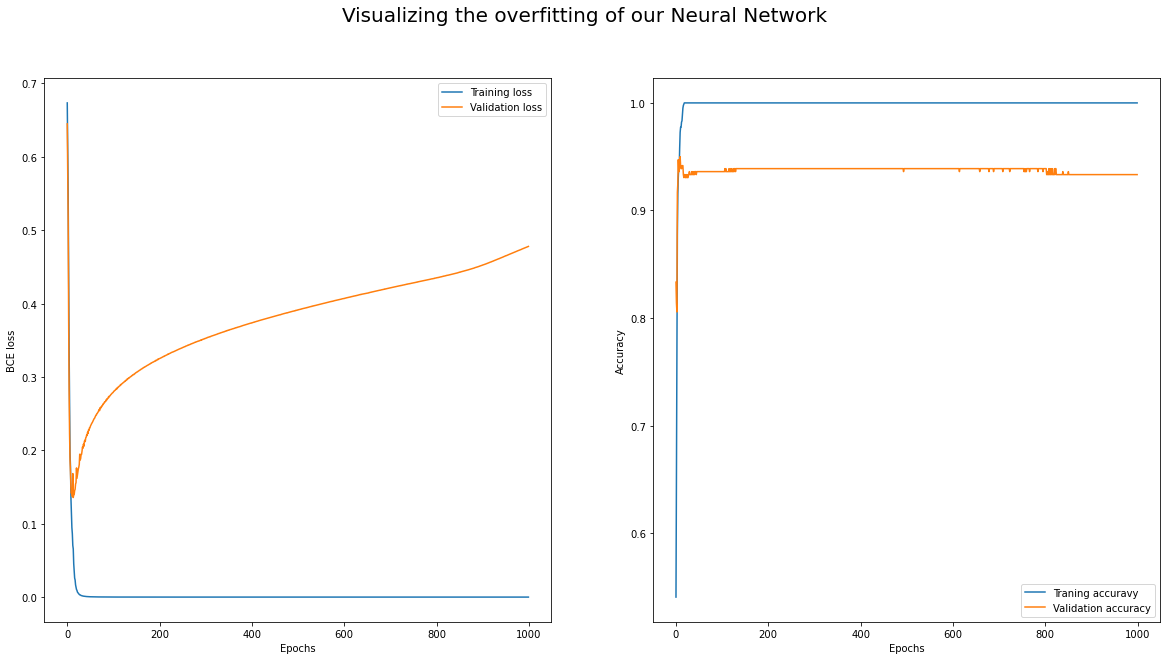

In [38]:
fig, axes = plt.subplots(1, 2, figsize= (20, 10))
plt.suptitle('Visualizing the overfitting of our Neural Network', size=20)
axes[0].plot(history.history['loss'], label='Training loss')
axes[0].plot(history.history['val_loss'], label='Validation loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('BCE loss')
axes[0].legend()
axes[1].plot(history.history['accuracy'], label='Traning accuravy')
axes[1].plot(history.history['val_accuracy'], label='Validation accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.show(fig)

**INTERPRETATION:**

We can tell that this model is overfitting because of the training vs validation loss and training vs validation accuracy. We can see that these measures keep on getting better for the training but start plateau-ing and even become worse for the validation set as we keep on training. This means that when we keep on training, our model detect patterns in the training set that are not present in the validation/testing set: it is overfitting. 

<a id="s23"></a>

<div class='exercise-r'>

**[2.3:](#q23) Regularize the overfit network**

Create an ANN that doesn't overfit and use it to [compete on Kaggle](#part2kaggle).

**DON'TS**

- **DO NOT change the architecture**. In other words, keep the same number of layers, same number of nodes, same activation function, and same loss function and output unit as was used in your question 2.2 overfit model. **No CNNs/RNNs/enhancements.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific KMNIST datasets provided to you (via the CS109A [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model (e.g., dropout, L2 norm, etc.).
 - **YOU CAN also** do data augmentation using the provided training data. 

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**

<a id="s231"></a>

**[2.3.1:](#q23)** Build and train your regularized model (you MUST adhere to the "DOS" and "DON'TS" listed above), print your model summary, and print your final training and validation accuracy and loss.
    
</div>

#### Data Augmentation: Random Rotation

In [39]:
"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
X_to_augm = np.expand_dims(X, axis=3)
datagen.fit(X_to_augm)
batch = datagen.flow(X_to_augm, y, batch_size=32)
"""

'\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\ndatagen = ImageDataGenerator(\n    featurewise_center=True,\n    featurewise_std_normalization=True,\n    rotation_range=20,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    horizontal_flip=True)\nX_to_augm = np.expand_dims(X, axis=3)\ndatagen.fit(X_to_augm)\nbatch = datagen.flow(X_to_augm, y, batch_size=32)\n'

#### Definition of Early Stopping 

In [40]:
callback_val = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)

#### Definition of L1 regularization

In [41]:
l1 = tf.keras.regularizers.l1(0.001)
l2 = tf.keras.regularizers.l2(0.001)

In [42]:
# your code here
dim_input = X.shape[1]
dim_output = 1 # binary classification
NN_model = tf.keras.models.Sequential(name='NN_model')
hidden_layers = 3  # depth
width_hidden_layers = 100
NN_model.add((tf.keras.layers.Dense(width_hidden_layers,input_dim=dim_input, activation = 'relu',name='hidden1', kernel_regularizer=l1)))
NN_model.add(tf.keras.layers.Dropout(0.3))
NN_model.add((tf.keras.layers.Dense(width_hidden_layers, activation = 'relu',name='hidden2', kernel_regularizer=l1)))
NN_model.add(tf.keras.layers.Dropout(0.3))
NN_model.add((tf.keras.layers.Dense(width_hidden_layers, activation = 'relu',name='hidden3', kernel_regularizer=l2)))
NN_model.add(tf.keras.layers.Dense(dim_output, activation = 'sigmoid',name='output'))
NN_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
history_reg = NN_model.fit(X, y, epochs=2000, batch_size=32, verbose=1, validation_split=0.15, callbacks=[callback_val])

Epoch 1/2000
32/32 [==============================] - 0s 9ms/step - loss: 3.9689 - accuracy: 0.5627 - val_loss: 3.0386 - val_accuracy: 0.6389
Epoch 2/2000
32/32 [==============================] - 0s 3ms/step - loss: 2.3592 - accuracy: 0.7755 - val_loss: 1.7309 - val_accuracy: 0.8222
Epoch 3/2000
32/32 [==============================] - 0s 3ms/step - loss: 1.3891 - accuracy: 0.9010 - val_loss: 1.0596 - val_accuracy: 0.9556
Epoch 4/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.9741 - accuracy: 0.9353 - val_loss: 0.8185 - val_accuracy: 0.9500
Epoch 5/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.7783 - accuracy: 0.9402 - val_loss: 0.6900 - val_accuracy: 0.9500
Epoch 6/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.9343 - val_loss: 0.6011 - val_accuracy: 0.9611
Epoch 7/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.5792 - accuracy: 0.9578 - val_loss: 0.5701 - val_accuracy: 0.9333
Epoch 

32/32 [==============================] - 0s 3ms/step - loss: 0.2499 - accuracy: 0.9735 - val_loss: 0.2901 - val_accuracy: 0.9389
Epoch 59/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.2393 - accuracy: 0.9745 - val_loss: 0.2900 - val_accuracy: 0.9389
Epoch 60/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.2677 - accuracy: 0.9578 - val_loss: 0.3036 - val_accuracy: 0.9389
Epoch 61/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.2534 - accuracy: 0.9686 - val_loss: 0.3302 - val_accuracy: 0.9500
Epoch 62/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.2547 - accuracy: 0.9716 - val_loss: 0.2984 - val_accuracy: 0.9444
Epoch 63/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.2603 - accuracy: 0.9657 - val_loss: 0.3148 - val_accuracy: 0.9389
Epoch 64/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.2196 - accuracy: 0.9863 - val_loss: 0.3423 - val_accuracy: 0.9333
Epoch 65/2000

32/32 [==============================] - 0s 3ms/step - loss: 0.2136 - accuracy: 0.9794 - val_loss: 0.3075 - val_accuracy: 0.9389
Epoch 116/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.2556 - accuracy: 0.9627 - val_loss: 0.3099 - val_accuracy: 0.9444
Epoch 117/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.2315 - accuracy: 0.9735 - val_loss: 0.3149 - val_accuracy: 0.9389
Epoch 118/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.2294 - accuracy: 0.9725 - val_loss: 0.3107 - val_accuracy: 0.9389
Epoch 119/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.1917 - accuracy: 0.9863 - val_loss: 0.3123 - val_accuracy: 0.9444
Epoch 120/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.1871 - accuracy: 0.9863 - val_loss: 0.3006 - val_accuracy: 0.9444
Epoch 121/2000
32/32 [==============================] - 0s 3ms/step - loss: 0.1736 - accuracy: 0.9912 - val_loss: 0.3144 - val_accuracy: 0.9500
Epoch 1

<a id="s232"></a>

<div class='exercise-r'>

**[2.3.2:](#q23)** Plot your model's training accuracy and validation accuracy as a function of epochs.

</div>

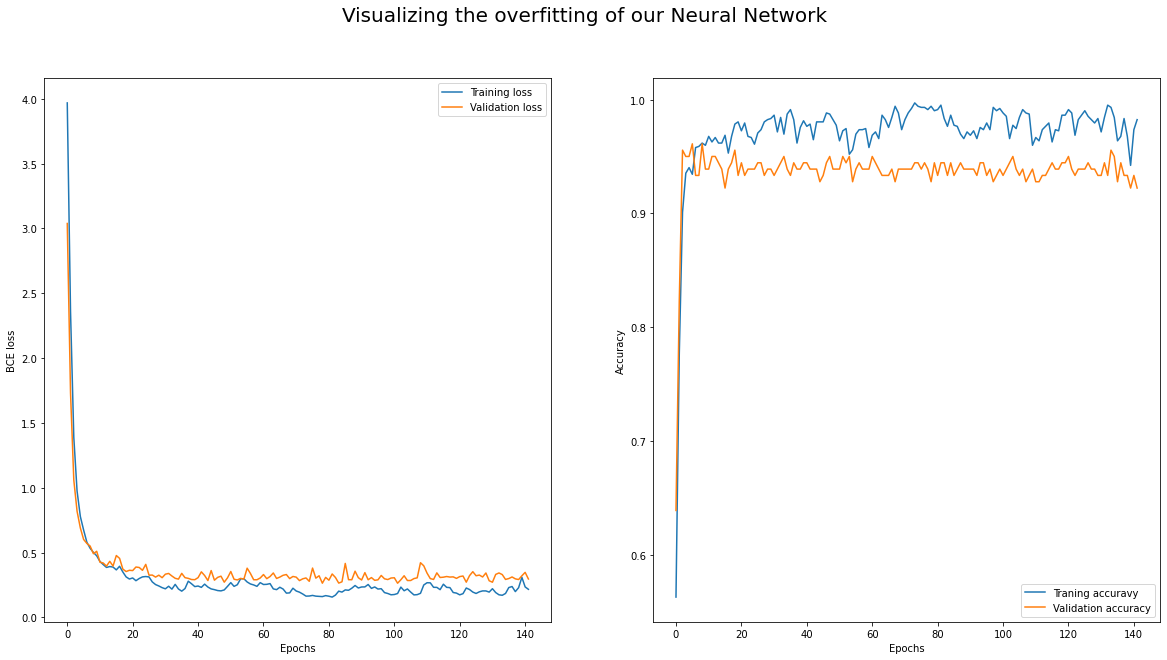

In [43]:
# your code here
fig, axes = plt.subplots(1, 2, figsize= (20, 10))
plt.suptitle('Visualizing the overfitting of our Neural Network', size=20)
axes[0].plot(history_reg.history['loss'], label='Training loss')
axes[0].plot(history_reg.history['val_loss'], label='Validation loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('BCE loss')
axes[0].legend()
axes[1].plot(history_reg.history['accuracy'], label='Traning accuravy')
axes[1].plot(history_reg.history['val_accuracy'], label='Validation accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.show(fig)

In [44]:
dim_input = X.shape[1]
dim_output = 1 # binary classification
NN_model = tf.keras.models.Sequential(name='NN_model')
hidden_layers = 3  # depth
width_hidden_layers = 100
NN_model.add((tf.keras.layers.Dense(width_hidden_layers,input_dim=dim_input, activation = 'relu',name='hidden1', kernel_regularizer=l1)))
NN_model.add(tf.keras.layers.Dropout(0.3))
NN_model.add((tf.keras.layers.Dense(width_hidden_layers, activation = 'relu',name='hidden2', kernel_regularizer=l1)))
NN_model.add(tf.keras.layers.Dropout(0.3))
NN_model.add((tf.keras.layers.Dense(width_hidden_layers, activation = 'relu',name='hidden3', kernel_regularizer=l2)))
NN_model.add(tf.keras.layers.Dense(dim_output, activation = 'sigmoid',name='output'))
NN_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
history_reg = NN_model.fit(X, y, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
38/38 [==============================] - 0s 2ms/step - loss: 3.8608 - accuracy: 0.5817
Epoch 2/20
38/38 [==============================] - 0s 2ms/step - loss: 2.1659 - accuracy: 0.7975
Epoch 3/20
38/38 [==============================] - 0s 2ms/step - loss: 1.2997 - accuracy: 0.9050
Epoch 4/20
38/38 [==============================] - 0s 2ms/step - loss: 0.9459 - accuracy: 0.9425
Epoch 5/20
38/38 [==============================] - 0s 2ms/step - loss: 0.7808 - accuracy: 0.9408
Epoch 6/20
38/38 [==============================] - 0s 2ms/step - loss: 0.7351 - accuracy: 0.9233
Epoch 7/20
38/38 [==============================] - 0s 2ms/step - loss: 0.6571 - accuracy: 0.9300
Epoch 8/20
38/38 [==============================] - 0s 2ms/step - loss: 0.5317 - accuracy: 0.9642
Epoch 9/20
38/38 [==============================] - 0s 2ms/step - loss: 0.5048 - accuracy: 0.9558
Epoch 10/20
38/38 [==============================] - 0s 2ms/step - loss: 0.4567 - accuracy: 0.9650
Epoch 11/20
38/38 [

<a id="s233"></a>

<div class='exercise-r'>

**[2.3.3:](#q23)** In several sentences, describe the approach you have taken to improve the performance of your regularized model in 2.3.1 and any observations you might have regarding your training and Kaggle results.

</div>

**APPROACH AND OBSERVATIONS:**

The approach I have taken:
- Early Stopping in order to prevent training our model for too long and therefore overfitting the trainign data
- I have tried L1 and L2 regularization on the network weights, L1 appeared to perform better so I sticked with it 
- I tried to vay the batch size and reduce it, in order to introduce stochasticity in the gradient descent and therefore be able to jump out of local optima
- I added dropout to prevent co-adaptability in the neurons and prevent them from learning unrealistic patterns from the training data. 

<a id="s234"></a>

<div class='exercise-r'>

**[2.3.4:](#q23)** Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS109A Kaggle Competition](#part2kaggle) for leaderboard scoring. **IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"id"` and needs to contain the test observation index numbers corresponding to each of your 2,000 predictions, the second must be named `"category"` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location.

</div>

In [45]:
# your code here
X_test = testing_images.values/255
predictions = 1*(NN_model.predict(X_test).flatten()> 0.5)
predictions = np.vstack((np.arange(2000), predictions)).T
preds = pd.DataFrame(predictions, columns=['id', 'category'])
preds.to_csv('Model_1.csv', index=False)

<a id="s235"></a>

<div class='exercise-r'>

**[2.3.5:](#q23)** **Specify your Kaggle name that you have used on the leaderboard**. We CAN NOT give you credit without this.

</div>

**YOUR KAGGLE LEADERBOARD NAME:**

David Assaraf cs109a

[Return to contents](#contents)